# Statistical test of Treatment A & B

This is the analysis of Treatment A & B for the novo case for presentation on 2022-03-28 @ 13.00



In [1]:
'''
This section will simply import the necessary modules to run the program. 
These are all standard Python modules, so nothing strange should happen here.
PLEASE have internet! 
'''
import sys
# Install modules, if not already installed, we could make this quiet, but it doesnt really matter
!{sys.executable} -m ensurepip
!{sys.executable} -m pip install numpy pandas matplotlib statistics openpyxl scipy nodejs

print('prereq modules installed')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import re

print('imported modules')

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /tmp/tmp4jckohfg
Defaulting to user installation because normal site-packages is not writeable
prereq modules installed
imported modules


# Clean up of data

This section entails the cleanup of data. 
To avoid data curruption, The cleaned up data is saved into two new sheet in in the file 'cleaned-data.xlsx'.

Initial data-inspection provided some thoughts.
As we need to provide a descriptive table, we have some small issues with the data.


For ADSL:
- Three subjects are missing DIABDUR. i.e. ADSL Line 16 (Subject S001047) Is missing entry at DIABDUR and DIABDURU, So we can expect a few other subjects to be missing some numbers
- S005025 is VERY tall. I believe it is a safe assumption that this subject was 181cm tall, and not 181 m tall, This should be corrected.
- Weight is noted in both LB and KG, however, the table specifies KG, so we should convert all lb to kg. 

For ADLB:
- Ensure we are not missing any data for Visit 10, 14, 18, 22, 26, 30. 
    
- We are dividing the data into two PARAMCD's (of interest here at least) (at a glance these two correspond to FPG and HbA1c.. I will have to check to make sure)
    - This might actually be smarter to seperate the data into two temporary dataframes here, so no confusion occurs here. And to ensure that no data is missing.
- There has also been some issues with a few of the acquisitions of data. see ANL01FL != 'Y'
    - see 'Retest Rule' and 'oroginal visit realloc'. Not sure what that means... 
        - In a real scenario I really should know this
- Lets also make sure that the units for FPG remains mmol/L and HbA1c remains %
- While we are checking, maybe some of the PARAM's are not only FPG or HbA1c.




In [2]:
# Specify variable constants

MASTER_XLSX_NAME : str = 'src/data.xlsx'
CLEAN_XLSX_NAME : str = 'src/clean-data.xlsx'


In [3]:
def convertHeightCorrectly(value:float, unit:str) -> float:
    """
    This function converts height from different unit (etc cm)
    to m.
    Also ensures that if height is < 100
    """
    
    unit_conv = float(value<100) + float(value>=100) * 0.01
    if unit.lower() != 'm':
        return np.nan

    return value * unit_conv

    
def converWgt2Kg(value:float, unit:str) -> float:
    """
    Converts weight into Kg
    - if lb -> wgt * fLB2KG
    else return wgt
    """
    fLB2KG = 0.4535924 # conversion ratio from lb to kg
    unit_conv = float(unit == 'lb') * fLB2KG + float(unit == 'kg')
    return value * unit_conv

def convertMonthsToYears(value:float, unit:str) -> float:
    """
    Convert months into years, if need be.
    """
    
    unit_conv = float(unit=='years' or unit=='years'.upper()) + float(unit=='months')*1.0/12.0
    return value * unit_conv

def extractWeekAndVisits(value:str, task:str): 
    """ This function returns a list of data with the week number"""
    
    # I would honestly like to do task to be an enum.. might just do that before submit
    
    nums = [int(i) for i in re.findall(r'\d+', value)]
    if task.lower() == 'visit':
        return nums[0]
    if task.lower() == 'week':
        return nums[1]

def handleADLBANL01FL(DF:pd.DataFrame) -> None:
    """
    There are two types of notes
    'original visit realloc'
    'Retest rule'
    When 'original visit realloc' is there, we see a copy of it
    We can therefore safely ignore all rows with 'original visit realloc'. 
    However, for the retest rule, I am not sure if this is the valid entry, or if it is the other one.
    I will assume (this is a case study) that it is sufficient to handle it by dropping these rows for the analysis.
    This means we keep all rows, when ANL01FL=='Y', and drop when ANL01FL=='N'.
    """
    return DF[DF['ANL01FL']=='Y'].copy()
    


In [4]:
def cleanADSL(DF:pd.DataFrame) -> pd.DataFrame:
    """ Returns cleaned data from ADSL dataframe """
    clean_df = pd.DataFrame()
    
    # Add the fixed Columns
    fixed_list_in = ['SUBJID', 'TRT01P', 'FASFL', 'SAFFL', ]
    fixed_list_out = ['SUBJID', 'Treatment','FASFL', 'SAFFL', ]
    clean_df[fixed_list_out] = DF[fixed_list_in]
    
    clean_df['AgeYears'] = DF.apply(lambda row: convertMonthsToYears(value=row.AGE, unit=row.AGEU), axis=1)
    clean_df['HeightM'] = DF.apply(lambda row: convertHeightCorrectly(value=row.HGTBL, unit=row.HGTBLU), axis=1)
    clean_df['BodyWeightKg'] = DF.apply(lambda row: converWgt2Kg(value=row.WGTBL, unit=row.WGTBLU), axis=1)
    clean_df['DiabetesDurationYears'] = DF.apply(lambda row: convertMonthsToYears(value=row.DIABDUR, unit=row.DIABDURU), axis=1)
    
    return clean_df.copy()

def cleanADLB(DF:pd.DataFrame) -> pd.DataFrame:
    """ Returns cleaned data in ADSL dataframe """
    clean_df = pd.DataFrame()
    
    # Add the fixed Columns
    fixed_list_in = ['SUBJID', 'TRTP', 'VISITNUM','FASFL', 'ANL01FL', 'ANL01REA', 'PARAMCD', 'AVAL', 'AVALU']
    fixed_list_out = ['SUBJID', 'Treatment', 'VISITNUM', 'FASFL',  'ANL01FL', 'ANL01REA', 'PARAMCD', 'AVAL', 'AVALU']
    clean_df[fixed_list_out] = DF[fixed_list_in]
    
    # Now seperate AVISIT into Visit and Week
    clean_df['Week'] = DF.apply(lambda row: extractWeekAndVisits(value=row.AVISIT, task='week'), axis=1)
    
    
    # Check that can be done to ensure that VISIT vs VISITNUM are the same (They are, for this data)
    #tmp_visit = DF.apply(lambda row: extractWeekAndVisits(value=row.AVISIT, task='visit'), axis=1) 
    #print( f"Is VISITNUM vs AVISIT_Visit equal? : {tmp_visit == ADLBdf['VISITNUM']).all()}") 
    
    clean_df = handleADLBANL01FL(DF=clean_df)
    
    
    return clean_df.copy()

In [5]:
# Open MASTER dataframe
ADSLdf : pd.DataFrame = pd.read_excel(MASTER_XLSX_NAME, sheet_name='ADSL')
ADLBdf : pd.DataFrame = pd.read_excel(MASTER_XLSX_NAME, sheet_name='ADLB')

# Clean Data
ADSL_clean : pd.DataFrame = cleanADSL(DF = ADSLdf) 
ADLB_clean : pd.DataFrame = cleanADLB(DF = ADLBdf)        



## Create data for baseline.



In [6]:
# This contains some functions for creating baseline tables
def createBaselineADLB(DF: pd.DataFrame):
    """ Generate baseline ADLB table """
    
    # filters for ADLB
    one = DF['PARAMCD']=='C64849B'
    two = DF['VISITNUM']==10
    three = DF['ANL01FL']=='Y'
    four = DF['FASFL']=='Y'
    
    return ADLB_clean[one & two & three & four].copy()

def getValueHbA1c(subject_name, ADLB):
    """ Return HbA
    """
    val =  ADLB[ADLB['SUBJID'] == subject_name].copy()['AVAL'].values
    # if val is not empty, return first datapoint
    if val.size>0:
        return val[0]

def populateTableShell(ADSL: pd.DataFrame, ADLB: pd.DataFrame) -> pd.DataFrame:
    """
    """
    TableShell = pd.DataFrame()
    col_ADSL = ['SUBJID', 'Treatment', 'AgeYears', 'HeightM', 'BodyWeightKg', 'DiabetesDurationYears']
    col_tbl = ['SUBJID', 'Treatment', 'Age (yrs)','Height (m)', 'Body Weight (kg)', 'Duration of Diabetes (yrs)']
    TableShell[col_tbl] = ADSL[col_ADSL].copy()

    TableShell['HbA1c (%)'] = ADSL.apply(lambda row: getValueHbA1c(subject_name=row.SUBJID, ADLB=ADLB),axis=1)
    #TableShell.set_index('SUBJID')
    return TableShell
    

In [7]:
# Base line ADLB
ADLB_baseline = createBaselineADLB(DF=ADLB_clean)



TableShell = populateTableShell(ADSL=ADSL_clean, ADLB=ADLB_baseline) 

# Check for dubl, this appears correct.
SUBJID_dublicated = TableShell[TableShell.duplicated(['SUBJID'])]
if len(SUBJID_dublicated):
    print(f"Number og dublicates in TableShell: {len(SUBJID_dublicated)}")

ADSLdf['Total'] = 'Total'
TableShell['Total'] = 'Total'
numcount_groups = ADSLdf.groupby('TRT01P')['SUBJID'].count()
numcount_totals = ADSLdf.groupby('Total')['SUBJID'].count()
counts = pd.concat([numcount_groups,numcount_totals])
summary_groups = TableShell.groupby('Treatment').describe(include=np.number)
summary_total = TableShell.groupby('Total').describe(include=np.number)
summary_groups = pd.concat([summary_groups, summary_total]).transpose()




In [8]:
# Lets present some data
rownames_for_summary = ['count','mean','std','min', 'max']
groups = summary_groups.index.get_level_values(0)

selected_rows = summary_groups.index.get_level_values(1).isin(rownames_for_summary)
summary_df = summary_groups[selected_rows].round(decimals=1)


# show data with 1 decimal.. doesnt make sense for count, but I will live with it.
summary_df.style.format(precision=1)

In [12]:
def extractMeans(DF, PARAMCD: str):
    """ This function to extract either Hb or FPG """
    
    # Filters
    one = ADLB_clean['PARAMCD']==PARAMCD
    two = ADLB_clean['FASFL']=='Y'
    three = ADLB_clean['ANL01FL']=='Y'
    
    # Filter data
    DF_out = ADLB_clean[one & two & three]
    
    # Group data by Treatment and Week
    DF_out = DF_out.groupby(['Treatment','Week'], as_index=False).mean().reset_index()
    
    return DF_out.copy()

def plotfunction(DF:pd.DataFrame,title:str, ylabel:str, plotbaseline):
    """ Generates plot of the 'AVAL' to figure """
    
    # Subplots
    fig, ax = plt.subplots()
    
    # If specified generate reference line (is hardcoded at Y=7.0)
    if plotbaseline:
        plt.plot(np.array([0.0,26.0]),np.array([7.0,7.0]), linestyle='dashed', color='gray')
        
    # Plot AVAL vs Week, grouped by Treatment
    for key,tmp_dataframe in DF.groupby('Treatment'):
        # Plot the data
        tmp_dataframe.plot('Week', 'AVAL', label=key, ax=ax)

    # Title and missing ylabel
    plt.title(title)
    plt.ylabel(ylabel)

# 'Figure 1 - mean plot of HbA1c (%) by time - full analysis set'
Here we are doing the plotting of figure 1, which contains the mean plot of HbA1c over time, using the full analysis set.

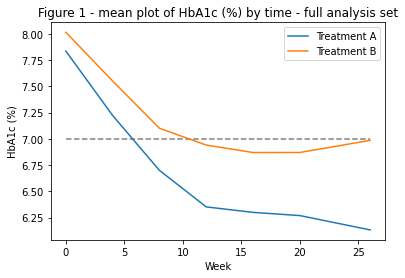

In [10]:
Fig1_Df_grouped_by_week = extractMeans(DF=ADLB_clean, PARAMCD='C64849B')
title = 'Figure 1 - mean plot of HbA1c (%) by time - full analysis set'
ylabel = 'HbA1c (%)'
plotfunction(DF=Fig1_Df_grouped_by_week,title=title, ylabel = ylabel, plotbaseline=True)

# Figure 2


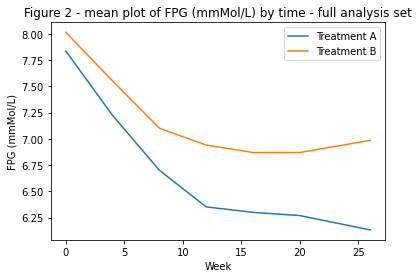

In [11]:
Fig2_Df_grouped_by_week = extractMeans(DF=ADLB_clean, PARAMCD='C105585P')
title = 'Figure 2 - mean plot of FPG (mmMol/L) by time - full analysis set'
ylabel = 'FPG (mmMol/L)'
plotfunction(DF=Fig1_Df_grouped_by_week,title=title, ylabel = ylabel, plotbaseline=False)